In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load Dataset
df = pd.read_csv("House_Rent_Dataset.csv")
print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (4746, 12)
    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3 

In [3]:
# Data Preprocessing
# Handle missing values (drop rows if any)
df.dropna(inplace=True)

# Encode categorical variables
categorical_cols = ["City", "Area Type", "Area Locality",
                    "Furnishing Status", "Tenant Preferred", "Point of Contact"]
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
num_cols = ["Size", "BHK", "Bathroom"]
df[num_cols] = scaler.fit_transform(df[num_cols])

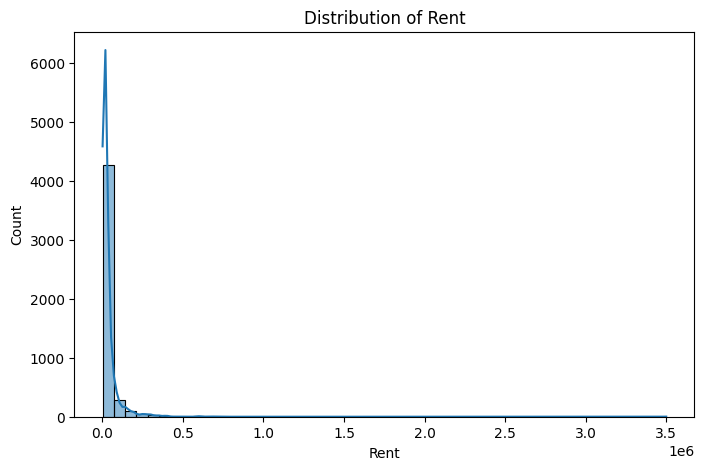

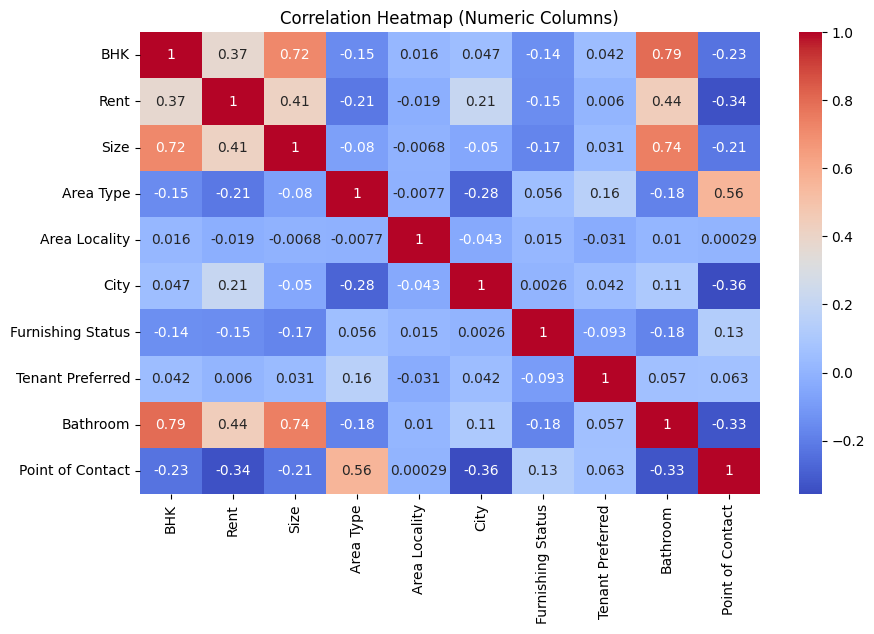

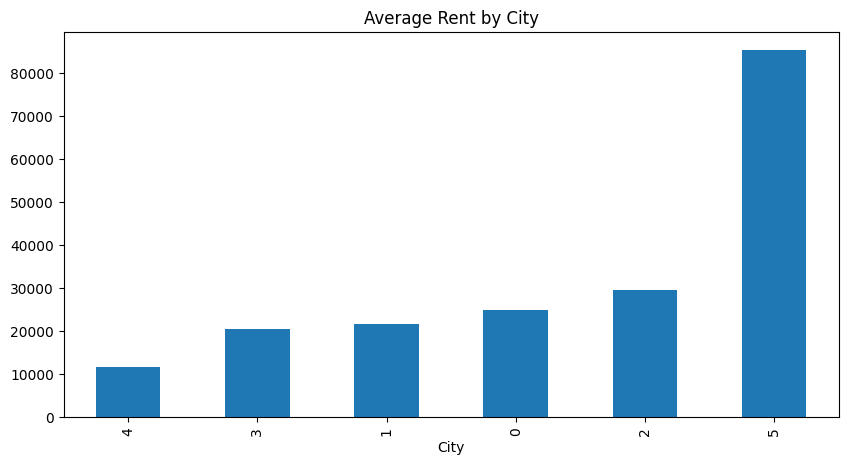

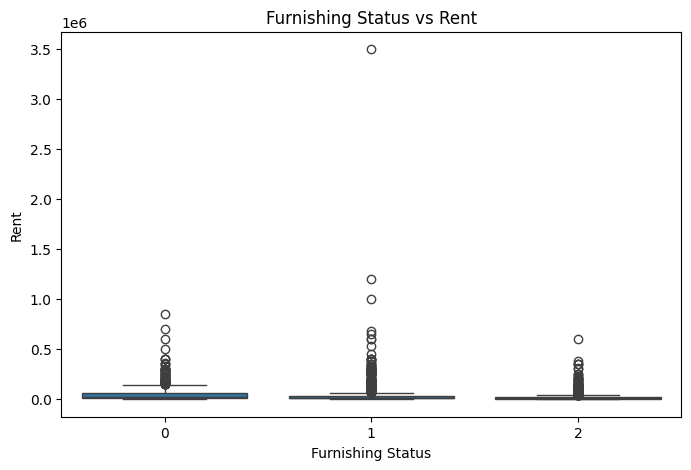

In [4]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(8,5))
sns.histplot(df["Rent"], bins=50, kde=True)
plt.title("Distribution of Rent")
plt.show()

# Only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Columns)")
plt.show()

# City-wise average rent
city_avg = df.groupby("City")["Rent"].mean().sort_values()
city_avg.plot(kind="bar", figsize=(10,5), title="Average Rent by City")
plt.show()

# Furnishing Status vs Rent
plt.figure(figsize=(8,5))
sns.boxplot(x="Furnishing Status", y="Rent", data=df)
plt.title("Furnishing Status vs Rent")
plt.show()


In [11]:
# Train/Test Split
X = df.drop("Rent", axis=1)
y = df["Rent"]

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64','float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
# Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective="reg:squarederror", random_state=42),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

In [15]:
# Model Training & Evaluation
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results[name] = (rmse, mae, r2)
    print(f"\n===== {name} =====")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")


===== Linear Regression =====
RMSE: 48944.50, MAE: 23527.27, R²: 0.40

===== Random Forest =====
RMSE: 37142.90, MAE: 11401.77, R²: 0.65

===== XGBoost =====
RMSE: 34700.60, MAE: 12367.72, R²: 0.70
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 3796, number of used features: 95
[LightGBM] [Info] Start training from score 35151.516333

===== LightGBM =====
RMSE: 38323.62, MAE: 13367.63, R²: 0.63


C:\Users\ittyavira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


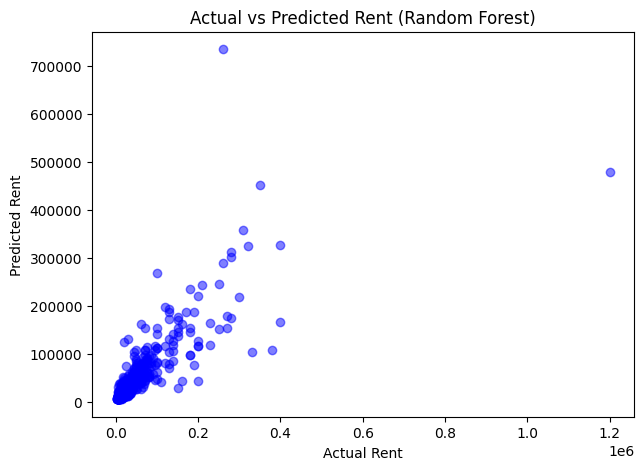

In [8]:
# Visualization - Actual vs Predicted 
best_model = models["Random Forest"]
preds = best_model.predict(X_test)

plt.figure(figsize=(7,5))
plt.scatter(y_test, preds, alpha=0.5, color="blue")
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("Actual vs Predicted Rent (Random Forest)")
plt.show()

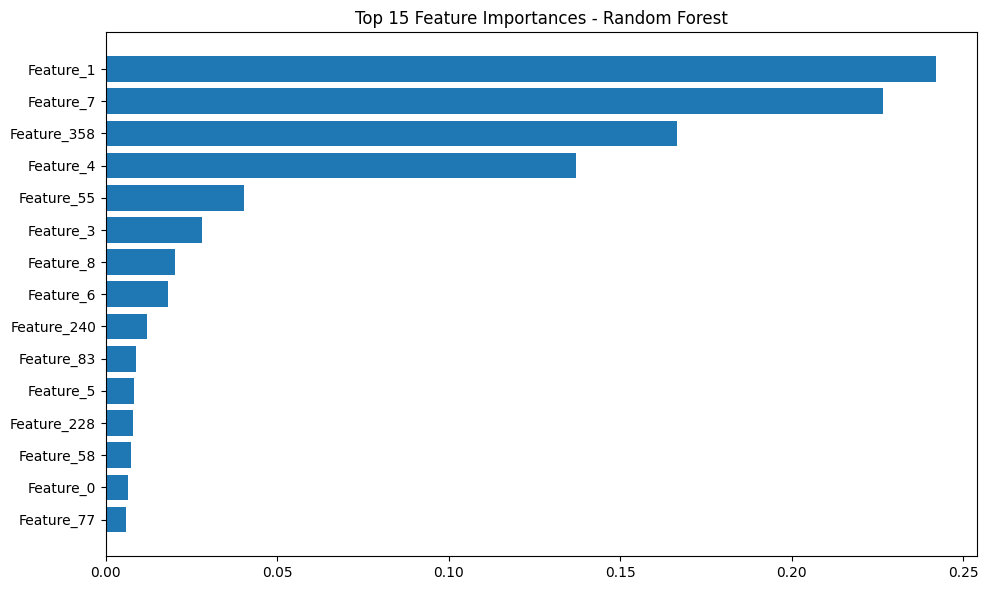

In [9]:
# Feature Importance 
# Convert to dense array
X_train_dense = X_train.toarray()

# You must supply column names manually (if you know them)
feature_names = [f"Feature_{i}" for i in range(X_train_dense.shape[1])]

importances = best_model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 15
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:top_n][::-1], feat_imp['Importance'][:top_n][::-1])
plt.title(f"Top {top_n} Feature Importances - Random Forest")
plt.tight_layout()
plt.show()